In [86]:
import numpy as np
import pandas as pd
import os
import math
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [87]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [88]:
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### EDA

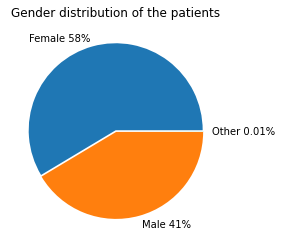

In [89]:
data.gender.value_counts(normalize=True)
y = np.array([2994, 2115, 1])
mylabels = ["Female 58%", "Male 41%", "Other 0.01%"]
plt.pie(y, labels = mylabels, explode=[0.01, 0.01, 0.01])
plt.title("Gender distribution of the patients")
plt.show() 

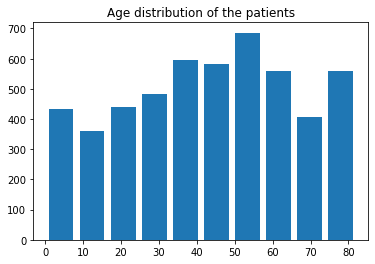

In [90]:
plt.hist(data.age, rwidth=0.8, density=False)
plt.title("Age distribution of the patients")
plt.show()

In [91]:
data.hypertension.value_counts(normalize=True)

0    0.902544
1    0.097456
Name: hypertension, dtype: float64

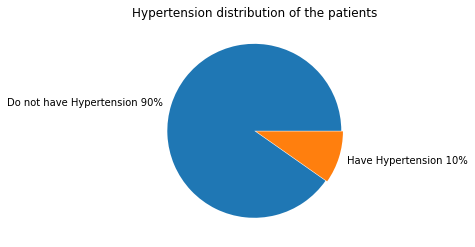

In [92]:
y = np.array([4612, 498])
mylabels = ["Do not have Hypertension 90%", "Have Hypertension 10%"]
plt.pie(y, labels = mylabels, explode=[0.01, 0.01])
plt.title("Hypertension distribution of the patients")
plt.show() 

In [93]:
data.heart_disease.value_counts(normalize=True)

0    0.945988
1    0.054012
Name: heart_disease, dtype: float64

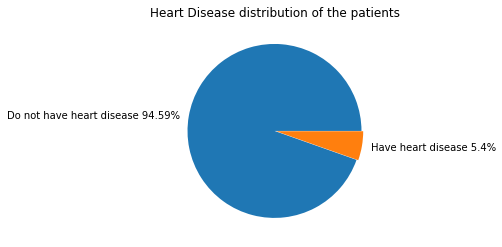

In [94]:
y = np.array([4834, 276])
mylabels = ["Do not have heart disease 94.59%", "Have heart disease 5.4%"]
plt.pie(y, labels = mylabels, explode=[0.01, 0.01])
plt.title("Heart Disease distribution of the patients")
plt.show() 

In [95]:
data.ever_married.value_counts(dropna=False)

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [96]:
data.work_type.value_counts(dropna=False)

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [97]:
data.Residence_type.value_counts(dropna=False)

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

<AxesSubplot:>

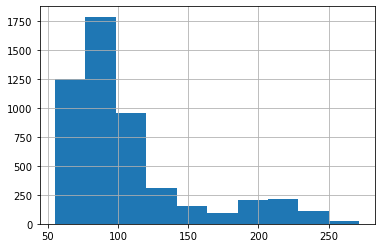

In [98]:
data.avg_glucose_level.hist()

<AxesSubplot:>

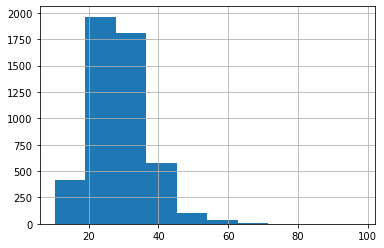

In [99]:
data.bmi.hist()

In [100]:
data.smoking_status.value_counts(dropna=False)

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [101]:
data.stroke.value_counts(dropna=False)

0    4861
1     249
Name: stroke, dtype: int64

In [102]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


In [103]:
def age_transform(x):
    if x < 20:
        return '0-20'
    elif x < 40:
        return '0-40'
    elif x < 60:
        return '40-60'
    elif x < 80:
        return '60-80'
    else:
        return '80+'

In [104]:
data['age_range'] = data['age'].apply(age_transform)

In [105]:
df_summary_table = data.pivot_table(values=['hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], index=['age_range', 'stroke', 'gender'], aggfunc={
    'hypertension': np.mean,
    'heart_disease': np.mean,
    'avg_glucose_level': np.mean,
    'bmi': np.mean
})

In [106]:
def color_negative_red(val):
    if round(val, 2) == 159.13:
        color = 'red'
    elif round(val,2) == 34.17:
        color = 'red'
    elif round(val, 2) == 0.44:
        color = 'red'
    elif round(val, 2) == 0.45:
        color = 'red'
    elif round(val, 2) == 145.73:
        color = 'orange'
    elif round(val, 2) == 32.80:
        color = 'orange'
    elif round(val, 4) == 0.2903:
        color = 'orange'
    elif round(val, 4) == 0.3226:
        color = 'orange'
    else:
        color = 'black'
    return 'color: %s' % color

s = df_summary_table.style.applymap(color_negative_red)
s

### Data Preprocessing

In [107]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,60-80
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,60-80
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,80+
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,40-60
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,60-80


In [108]:
numeric_features = ["age", "avg_glucose_level", "bmi"]

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),  
           ("scaler", StandardScaler())] #z-score
)

categorical_features = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


### Model Training

In [109]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())]
)

In [110]:
X = data.iloc[:, 1:-1]

In [111]:
y = data.iloc[:, -1]

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [113]:
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.966


C:\Users\tony_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### PCA

In [114]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [115]:
cat_col_df = data[categorical_features]

In [116]:
one_hot_encoder.fit(cat_col_df)

OneHotEncoder(handle_unknown='ignore')

In [117]:
one_hot_encoder.categories_

[array(['Female', 'Male', 'Other'], dtype=object),
 array([0, 1], dtype=int64),
 array([0, 1], dtype=int64),
 array(['No', 'Yes'], dtype=object),
 array(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'],
       dtype=object),
 array(['Rural', 'Urban'], dtype=object),
 array(['Unknown', 'formerly smoked', 'never smoked', 'smokes'],
       dtype=object)]

In [118]:
one_hot_df = pd.DataFrame(one_hot_encoder.transform(data[categorical_features]).toarray())

In [119]:
one_hot_df.shape

(5110, 20)

In [120]:
one_hot_df.columns=['Female', 'Male', 'Other', 'hypertension_0', 'hypertension_1', 'heart_disease_0', 'heart_disease_1', 'not_married', 'married', 'Govt_job',
                  'Never_worked', 'Private', 'Self-employed', 'children', 'Rural', 'Urban', 'Unknown', 'formerly_smoked', 'never_smoked', 'smokes']

In [121]:
one_hot_df

,Female,Male,Other,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,not_married,married,Govt_job,Never_worked,Private,Self-employed,children,Rural,Urban,Unknown,formerly_smoked,never_smoked,smokes
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5106,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [122]:
num_col_df = data[numeric_features]

In [123]:
num_col_df

,age,avg_glucose_level,bmi
0,67.0,228.69,36.6
1,61.0,202.21,NaN
2,80.0,105.92,32.5
3,49.0,171.23,34.4
4,79.0,174.12,24.0
...,...,...,...
5105,80.0,83.75,NaN
5106,81.0,125.20,40.0
5107,35.0,82.99,30.6
5108,51.0,166.29,25.6


In [124]:
scaler = StandardScaler()
median_imputer = SimpleImputer(strategy="median")
median_imputer.fit(num_col_df)
imputed_df = pd.DataFrame(median_imputer.transform(num_col_df))
scaler.fit(imputed_df)
scaler_df = pd.DataFrame(scaler.transform(imputed_df))

In [125]:
scaler_df.columns = ['age_std', 'avg_glucose_level_std', 'bmi_std']

In [126]:
full_data = one_hot_df.merge(scaler_df, left_index=True, right_index=True)

In [127]:
pca = PCA()
X_pca = pca.fit_transform(full_data)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_pca.shape[1] - n_over_95 + 1

In [128]:
print("Number features: {0}, Total Variance Explained: {1}".format(n_to_reach_95, total_explained_variance[n_to_reach_95-1]))

Number features: 11, Total Variance Explained: 0.9526782238274881


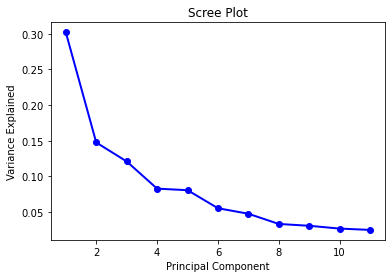

In [129]:
pca = PCA(n_components=11)
pca_fit = pca.fit(full_data)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [130]:
print(pca.explained_variance_ratio_)

[0.30214532 0.14754053 0.12097061 0.08280621 0.08063472 0.05532417
 0.04758203 0.0332673  0.03070709 0.02678073 0.02491951]


In [387]:
X_pca = full_data

In [388]:
y_pca = data.iloc[:, -1]

In [389]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=0)

In [390]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95)),
                 ('clf', RandomForestClassifier())])

pipe.fit(X_train_pca,y_train_pca)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=11)),
                ('clf', RandomForestClassifier())])

In [391]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_pca.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

In [392]:
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

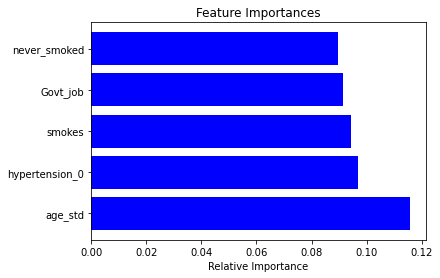

In [393]:
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:5]
top_importances = importances[:5]
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

In [394]:
print("model score: %.3f" % pipe.score(X_test_pca,y_test_pca))

model score: 0.945
